Importy i start klienta

In [7]:
import binance
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime
import re
client = binance.Client()

In [8]:
def get_data(asset):
    candles = client.get_klines(symbol=asset, interval='1m')
    df = pd.DataFrame(candles, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
									'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
									'Taker buy quote asset volume', 'Ignore']).astype("float") # bo domyślnie to są stringi xd
    # Wzór na RSI kradziony z https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down
    df['RSI'] = 100 - (100/(1 + rs))
    # Średnie kroczące 
    # Przykładowe długości okien https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp
    df["FMA"] = df["Close"].rolling(window=5).mean()
    df["SMA"] = df["Close"].rolling(window=13).mean()
    # Wyrzucamy pierwsze 14 dni żeby mieć wiarygodne wartości RSI
    df = df.iloc[14:]
    return df

def plot_data_moving_averages(symbol, df):
    # kradzione z https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Candlestick(x=df['Close time'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'], name=symbol))
    fig.add_trace(go.Scatter(x=df['Close time'], 
                            y=df['FMA'], 
                            opacity=0.7, 
                            line=dict(color='green', width=2), 
                            name='FMA'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df['Close time'], 
                            y=df['SMA'], 
                            opacity=0.7, 
                            line=dict(color='red', width=2), 
                            name='SMA'), secondary_y=False)
    fig.show()


def plot_data_rsi(symbol, df):
    # kradzione z https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Candlestick(x=df['Close time'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'], name=symbol))
    fig.add_trace(go.Scatter(x=df['Close time'], 
                            y=df['RSI'], 
                            opacity=0.7, 
                            line=dict(color='blue', width=2), 
                            name='RSI'), secondary_y=True)
    fig.show()

In [9]:
plot_data_moving_averages("ATOMUSDT", get_data("ATOMUSDT"))
plot_data_rsi("ATOMUSDT", get_data("ATOMUSDT"))

Spread na podstawie order booków

Ask = 4.718
Bid = 4.715
Spread = 0.003


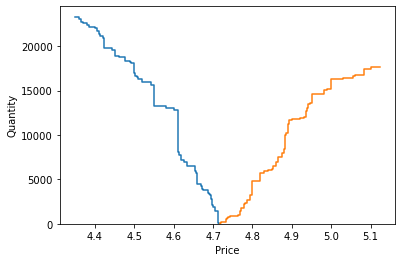

In [10]:
# inspired by https://tiao.io/post/exploring-the-binance-cryptocurrency-exchange-api-orderbook/

data = client.get_order_book(symbol = "ACMUSDT")
bids = pd.DataFrame(data["bids"], columns= {"price", "quantity"}).astype('float')
asks = pd.DataFrame(data["asks"], columns= {"price", "quantity"}).astype('float')

print("Ask = " + str(min(asks["price"])))
print("Bid = " + str(max(bids["price"])))
print("Spread = " + str(round(min(asks["price"]) - max(bids["price"]), 4)))
fig, ax = plt.subplots()

sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bids, ax=ax)
sns.ecdfplot(x="price", weights="quantity", stat="count", data=asks, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

SMA vs FMA - generowanie sygnału

In [11]:
wallet = 1000
symbol = "ACMUSDT"
data = get_data(symbol)
# generowanie sygnałów buy/sell
data['signal'] = 0.0
data['signal'] = np.where(data["FMA"] > data["SMA"], 1.0, 0.0)
data['position'] = data['signal'].diff()
data['position'] = data['position'].map({1: 'buy', -1: 'sell'})

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): # wyświetla cały dataframe
#     display(data)

data

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,RSI,FMA,SMA,signal,position
14,1.647495e+12,4.671,4.671,4.670,4.670,11.0,1.647495e+12,51.3746,2.0,0.0,0.0000,0.0,39.194714,4.6756,4.668154,1.0,NaN
15,1.647495e+12,4.670,4.670,4.670,4.670,0.0,1.647495e+12,0.0000,0.0,0.0,0.0000,0.0,39.194714,4.6752,4.669231,1.0,NaN
16,1.647495e+12,4.670,4.670,4.670,4.670,0.0,1.647495e+12,0.0000,0.0,0.0,0.0000,0.0,39.194714,4.6748,4.669462,1.0,NaN
17,1.647495e+12,4.670,4.670,4.670,4.670,0.0,1.647495e+12,0.0000,0.0,0.0,0.0000,0.0,39.194714,4.6724,4.670231,1.0,NaN
18,1.647495e+12,4.670,4.670,4.670,4.670,0.0,1.647495e+12,0.0000,0.0,0.0,0.0000,0.0,39.194714,4.6700,4.670385,0.0,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.647524e+12,4.721,4.724,4.721,4.724,192.0,1.647524e+12,906.6947,7.0,192.0,906.6947,0.0,55.986992,4.7220,4.718308,1.0,NaN
496,1.647524e+12,4.724,4.724,4.724,4.724,0.0,1.647524e+12,0.0000,0.0,0.0,0.0000,0.0,55.986992,4.7224,4.718846,1.0,NaN
497,1.647524e+12,4.724,4.724,4.724,4.724,2.1,1.647524e+12,9.9204,1.0,2.1,9.9204,0.0,55.986992,4.7228,4.719923,1.0,NaN
498,1.647524e+12,4.724,4.724,4.724,4.724,6.0,1.647524e+12,28.3440,1.0,6.0,28.3440,0.0,55.986992,4.7232,4.720385,1.0,NaN


FMA vs SMA - wykres

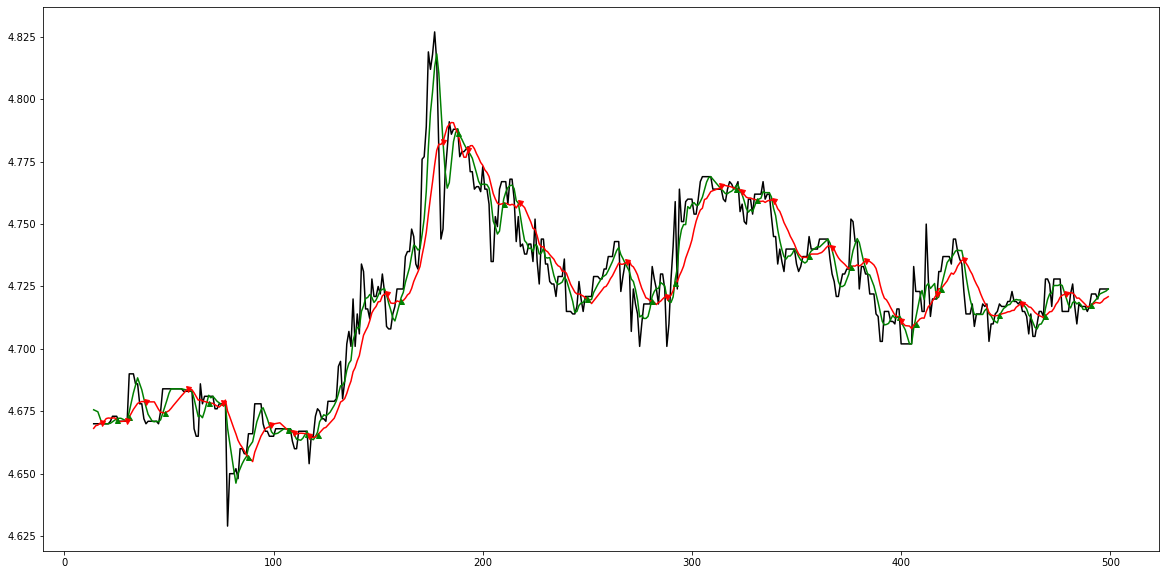

In [12]:
# plot_data_moving_averages(symbol, get_data(symbol))
# kradzione z https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a

plt.figure(figsize = (20,10)) 
data['Close'].plot(color = 'k', label= 'Close Price') 
data['FMA'].plot(color = 'green',label = 'FMA') 
data['SMA'].plot(color = 'red', label = 'SMA')

plt.plot(data[data['position'] == 'buy'].index, 
         data['SMA'][data['position'] == 'buy'], 
         '^', markersize = 5, color = 'g', label = 'buy')

plt.plot(data[data['position'] == 'sell'].index, 
         data['SMA'][data['position'] == 'sell'], 
         'v', markersize = 5, color = 'r', label = 'sell')